#COVID-19 
Análisis del impacto de diferentes factores socio-demograficos y comorbilidades sobre el Riesgo de Fallecimiento por COVID-19.
Utilizando Machine learning por aprendizaje supervisado.


In [ ]:
# Ocultar Warnings
from warnings import filterwarnings
filterwarnings('ignore')

In [ ]:
# Instalación de librerios que no estan por defecto en colab
!pip install lightgbm &> /dev/null
!pip install catboost &> /dev/null
!pip install pandas-profiling==2.7.1 &> /dev/null
!pip install shap &> /dev/null
# !pip install plotly_express &> /dev/null

# Importar librerias

In [ ]:
# Importar Librerias
import pandas as pd
from pandas_profiling import ProfileReport
import numpy as np
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import BorderlineSMOTE
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score
import plotly.figure_factory as ff
import plotly.graph_objects as go
import shap

In [ ]:
shap.initjs()

# Importar datos


In [ ]:
# Carga de datos y eliminación de variables categorizadas
data = pd.read_excel("/content/BGA Covid (DATABASE).xls")
data.drop([
    'per_etn_', 'Adulto_Mayor', 'Edad0_20', 'Edad21_40', 'Edad41_60',
    'Edad61_80', 'NS_Alto', 'NS_Medio', 'NS_Bajo', 'Comorbilidad', 'semana'
], axis=1, inplace=True)
data.estrato = data.estrato.replace(' ', np.nan)
data.head()

,edad_,hombre_,estrato,gp_discapa,gp_desplaz,gp_migrant,gp_carcela,gp_gestan,gp_indigen,gp_mad_com,gp_desmovi,gp_psiquia,gp_vic_vio,trab_salud,viajó,asma,epoc,diabetes,vih,enf_card,cancer,desnutricion,obesidad,ins_renal,fumador,tuberculos,Fallecido,Edad80mas
0,36,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,62,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,34,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,51,1,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,14,0,NaN,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Exploración de Datos
# profile = ProfileReport(data)
# profile.to_notebook_iframe()

In [ ]:
# Rellenar datos de estrato preservando la distribución
estrato, counts = np.unique(data.loc[~data.estrato.isna(),'estrato'].values, return_counts=True)
p = counts/counts.sum()
n = data.loc[data.estrato.isna()].shape[0]
data.loc[data.estrato.isna(), 'estrato'] = np.random.choice(6, n, p=p)
data['estrato'] = data.estrato.astype(int)



#Perfilamiento de los datos

In [ ]:
# Exploración de Datos
# profile = ProfileReport(data)
# profile.to_notebook_iframe()

# Separación  de Datos

In [ ]:
# Selección de Variable Objetivo
target = 'Fallecido'
features = [
  'edad_',
 'hombre_',
 'estrato',
 'gp_discapa',
 #'gp_desplaz',
 #'gp_migrant',
 #'gp_carcela',
 'gp_gestan',
 #'gp_indigen',
 #'gp_mad_com',
 #'gp_desmovi',
 'gp_psiquia',
 #'gp_vic_vio',
 #'trab_salud',
 #'viajó',
 'asma',
 'epoc',
 'diabetes',
 'vih',
 'enf_card',
 'cancer',
 'desnutricion',
 'obesidad',
 'ins_renal',
 'fumador',
 'tuberculos',
 #'Edad80mas'
]
X = data[features]
y = data[target]

## Tunning the los parametros de cada modelo sklearn usando validación cruzada.

In [ ]:
!pip install -q optuna

In [ ]:
import optuna
from optuna import trial
import optuna.integration as opt
from sklearn.model_selection import KFold, cross_val_score, cross_validate

In [ ]:
# Separación del Set de Pruebas: Prevención de Overfitting al Sistema Aumentado
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=1234)

## Tunning para el random Forest

In [ ]:
# definir la funcion objetivo con los parametros a optimizar
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True)
    max_leaf_nodes = trial.suggest_int("max_leaf_nodes", 2, 32, log=True) 
    clf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, max_leaf_nodes=max_leaf_nodes, random_state=0)
    score = cross_val_score(clf, X_train_val, y_train_val, n_jobs=-1, cv=KFold(n_splits=3))
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2021-03-24 06:00:25,972] A new study created in memory with name: no-name-f84a2f5a-357b-4771-9ee8-51e59c04c3d3
[I 2021-03-24 06:00:31,608] Trial 0 finished with value: 0.964114259116973 and parameters: {'n_estimators': 395, 'max_depth': 12, 'max_leaf_nodes': 2}. Best is trial 0 with value: 0.964114259116973.
[I 2021-03-24 06:00:36,192] Trial 1 finished with value: 0.964114259116973 and parameters: {'n_estimators': 315, 'max_depth': 26, 'max_leaf_nodes': 9}. Best is trial 0 with value: 0.964114259116973.
[I 2021-03-24 06:00:39,955] Trial 2 finished with value: 0.9640542504155897 and parameters: {'n_estimators': 267, 'max_depth': 4, 'max_leaf_nodes': 23}. Best is trial 0 with value: 0.964114259116973.
[I 2021-03-24 06:00:42,634] Trial 3 finished with value: 0.9640542504155897 and parameters: {'n_estimators': 188, 'max_depth': 4, 'max_leaf_nodes': 21}. Best is trial 0 with value: 0.964114259116973.
[I 2021-03-24 06:00:47,659] Trial 4 finished with value: 0.964114259116973 and parameter

In [ ]:
print("Mejor acc:", study.best_value)
best_params_rf = study.best_params
print("Mejores parametros:", best_params_rf)

Mejor acc: 0.964114259116973
Mejores parametros: {'n_estimators': 395, 'max_depth': 12, 'max_leaf_nodes': 2}


## Gradient Boosting classifier

In [ ]:
# definir la funcion objetivo con los parametros a optimizar
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 400)
    max_depth = trial.suggest_int("max_depth", 2, 32, log=True) 
    subsample = trial.suggest_discrete_uniform("subsample", 0.1, 1.0, 0.1)
    clf = GradientBoostingClassifier(subsample=subsample, 
                                     n_estimators=n_estimators,
                                     max_depth=max_depth, random_state=0)
    score = cross_val_score(clf, X_train_val, y_train_val, n_jobs=-1, cv=KFold(n_splits=3))
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2021-03-24 06:10:59,703] A new study created in memory with name: no-name-df997412-a66f-444e-8819-eb7bf1d8f2ac
[I 2021-03-24 06:11:01,750] Trial 0 finished with value: 0.9641142078020927 and parameters: {'n_estimators': 54, 'max_depth': 2, 'subsample': 0.4}. Best is trial 0 with value: 0.9641142078020927.
[I 2021-03-24 06:11:04,151] Trial 1 finished with value: 0.963664157396026 and parameters: {'n_estimators': 79, 'max_depth': 3, 'subsample': 1.0}. Best is trial 0 with value: 0.9641142078020927.
[I 2021-03-24 06:11:21,269] Trial 2 finished with value: 0.9583233154533385 and parameters: {'n_estimators': 115, 'max_depth': 32, 'subsample': 0.4}. Best is trial 0 with value: 0.9641142078020927.
[I 2021-03-24 06:11:23,422] Trial 3 finished with value: 0.963364119290676 and parameters: {'n_estimators': 91, 'max_depth': 4, 'subsample': 0.30000000000000004}. Best is trial 0 with value: 0.9641142078020927.
[I 2021-03-24 06:11:26,645] Trial 4 finished with value: 0.963004056279244 and paramet

In [ ]:
print("Mejor acc:", study.best_value)
best_params_gb = study.best_params
print("Mejores parametros:", best_params_gb)

Mejor acc: 0.9643542750170236
Mejores parametros: {'n_estimators': 180, 'max_depth': 2, 'subsample': 0.5}


## Tunning para CATBoost

In [ ]:
# definir la funcion objetivo con los parametros a optimizar
def objective(trial):
    param = {
        "objective": trial.suggest_categorical("objective", ["Logloss", "CrossEntropy"]),
        "colsample_bylevel": trial.suggest_float("colsample_bylevel", 0.01, 0.1),
        "depth": trial.suggest_int("depth", 1, 12),
        "boosting_type": trial.suggest_categorical("boosting_type", ["Ordered", "Plain"]),
        "bootstrap_type": trial.suggest_categorical(
            "bootstrap_type", ["Bayesian", "Bernoulli", "MVS"]
        ),
        "used_ram_limit": "3gb",
    }

    if param["bootstrap_type"] == "Bayesian":
        param["bagging_temperature"] = trial.suggest_float("bagging_temperature", 0, 10)
    elif param["bootstrap_type"] == "Bernoulli":
        param["subsample"] = trial.suggest_float("subsample", 0.1, 1)

    clf = CatBoostClassifier(**param)
    score = cross_val_score(clf, X_train_val, y_train_val, n_jobs=-1, cv=KFold(n_splits=3))
    accuracy = score.mean()
    return accuracy


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=20)

[I 2021-03-24 06:17:36,651] A new study created in memory with name: no-name-5fb080cc-4856-4f88-a787-fbbddc2b7117
[I 2021-03-24 06:17:56,295] Trial 0 finished with value: 0.9642042411100413 and parameters: {'objective': 'CrossEntropy', 'colsample_bylevel': 0.06533305794427283, 'depth': 11, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 5.543177171388209}. Best is trial 0 with value: 0.9642042411100413.
[I 2021-03-24 06:18:40,311] Trial 1 finished with value: 0.9645042981208732 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.06921893535181689, 'depth': 9, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.7030064937593916}. Best is trial 1 with value: 0.9645042981208732.
[I 2021-03-24 06:18:55,014] Trial 2 finished with value: 0.9642342306064254 and parameters: {'objective': 'Logloss', 'colsample_bylevel': 0.013904769240708967, 'depth': 7, 'boosting_type': 'Plain', 'bootstrap_type': 'Bayesian', 'bagging_temp

In [ ]:
print("Mejor acc:", study.best_value)
best_params_cb = study.best_params
print("Mejores parametros:", best_params_cb)

Mejor acc: 0.9645343065227397
Mejores parametros: {'objective': 'Logloss', 'colsample_bylevel': 0.07382993098415536, 'depth': 10, 'boosting_type': 'Ordered', 'bootstrap_type': 'Bernoulli', 'subsample': 0.9960755641533863}


## Tunning para LIGHTGBM

In [ ]:
# crear el dataset de solo train para realizar la validación cruzada
dtrain = opt.lightgbm.Dataset(X_train_val, label=y_train_val)

In [ ]:
# definir los parametros y los rangos que quiero cambiar
params = {
        'objective': 'binary',
        'metric': 'binary_error',#'binary_logloss'
        "verbosity": -1,
        "boosting_type": "gbdt",                
        "seed": 42
        }

In [ ]:
# crear el tuner, solo realizamos 3 particiones de los datos de train, por defecto se hace estratificado y aleatorio
tuner = opt.lightgbm.LightGBMTunerCV(
        params, dtrain, verbose_eval=100, early_stopping_rounds=100, folds=KFold(n_splits=3)
    )

[I 2021-03-24 05:45:47,839] A new study created in memory with name: no-name-1546d770-4243-49c6-8b62-28739bab30ba


In [ ]:
# ejecutar la busqueda
tuner.run()


feature_fraction, val_score: 0.035886:  14%|#4        | 1/7 [00:00<00:04,  1.22it/s][I 2021-03-24 05:45:50,787] Trial 0 finished with value: 0.03588577869399146 and parameters: {'feature_fraction': 0.8}. Best is trial 0 with value: 0.03588577869399146.

feature_fraction, val_score: 0.035886:  14%|#4        | 1/7 [00:00<00:04,  1.22it/s]

[100]	cv_agg's binary_error: 0.0367259 + 0.00141814



feature_fraction, val_score: 0.035676:  29%|##8       | 2/7 [00:01<00:04,  1.12it/s][I 2021-03-24 05:45:51,731] Trial 1 finished with value: 0.03567574688875855 and parameters: {'feature_fraction': 0.8999999999999999}. Best is trial 1 with value: 0.03567574688875855.

feature_fraction, val_score: 0.035676:  29%|##8       | 2/7 [00:01<00:04,  1.12it/s]

[100]	cv_agg's binary_error: 0.0369359 + 0.00119814



feature_fraction, val_score: 0.035676:  43%|####2     | 3/7 [00:02<00:03,  1.06it/s][I 2021-03-24 05:45:52,735] Trial 2 finished with value: 0.03585577299290826 and parameters: {'feature_fraction': 0.6}. Best is trial 1 with value: 0.03567574688875855.

feature_fraction, val_score: 0.035676:  43%|####2     | 3/7 [00:02<00:03,  1.06it/s]

[100]	cv_agg's binary_error: 0.0364559 + 0.0012821



feature_fraction, val_score: 0.035676:  57%|#####7    | 4/7 [00:03<00:02,  1.11it/s][I 2021-03-24 05:45:53,569] Trial 3 finished with value: 0.03585577569369142 and parameters: {'feature_fraction': 0.5}. Best is trial 1 with value: 0.03567574688875855.

feature_fraction, val_score: 0.035676:  57%|#####7    | 4/7 [00:03<00:02,  1.11it/s]

[100]	cv_agg's binary_error: 0.0365459 + 0.00121066
[100]	cv_agg's binary_error: 0.0364859 + 0.00094561



feature_fraction, val_score: 0.035676:  71%|#######1  | 5/7 [00:04<00:01,  1.02it/s][I 2021-03-24 05:45:54,698] Trial 4 finished with value: 0.03570574448749223 and parameters: {'feature_fraction': 0.7}. Best is trial 1 with value: 0.03567574688875855.

feature_fraction, val_score: 0.035676:  86%|########5 | 6/7 [00:05<00:00,  1.03it/s][I 2021-03-24 05:45:55,631] Trial 5 finished with value: 0.03573574748779226 and parameters: {'feature_fraction': 1.0}. Best is trial 1 with value: 0.03567574688875855.

feature_fraction, val_score: 0.035676:  86%|########5 | 6/7 [00:05<00:00,  1.03it/s]

[100]	cv_agg's binary_error: 0.037086 + 0.00102993



feature_fraction, val_score: 0.035646: 100%|##########| 7/7 [00:06<00:00,  1.07it/s]

num_leaves, val_score: 0.035646:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_error: 0.0358858 + 0.00117277



num_leaves, val_score: 0.035496:   5%|5         | 1/20 [00:01<00:21,  1.12s/it][I 2021-03-24 05:45:57,655] Trial 7 finished with value: 0.03549571808382567 and parameters: {'num_leaves': 186}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:   5%|5         | 1/20 [00:01<00:21,  1.12s/it]

[100]	cv_agg's binary_error: 0.0366059 + 0.000846826



num_leaves, val_score: 0.035496:  10%|#         | 2/20 [00:02<00:17,  1.02it/s][I 2021-03-24 05:45:58,543] Trial 8 finished with value: 0.03552572918647522 and parameters: {'num_leaves': 56}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  10%|#         | 2/20 [00:02<00:17,  1.02it/s]

[100]	cv_agg's binary_error: 0.0360958 + 0.000956185



num_leaves, val_score: 0.035496:  15%|#5        | 3/20 [00:03<00:18,  1.07s/it][I 2021-03-24 05:45:59,711] Trial 9 finished with value: 0.035525723784908876 and parameters: {'num_leaves': 206}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  15%|#5        | 3/20 [00:03<00:18,  1.07s/it]

[100]	cv_agg's binary_error: 0.0364859 + 0.000931828



num_leaves, val_score: 0.035496:  20%|##        | 4/20 [00:04<00:17,  1.08s/it][I 2021-03-24 05:46:00,823] Trial 10 finished with value: 0.03552572378490887 and parameters: {'num_leaves': 170}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  20%|##        | 4/20 [00:04<00:17,  1.08s/it]

[100]	cv_agg's binary_error: 0.0365459 + 0.00089231



num_leaves, val_score: 0.035496:  25%|##5       | 5/20 [00:05<00:16,  1.10s/it][I 2021-03-24 05:46:01,956] Trial 11 finished with value: 0.03549571808382567 and parameters: {'num_leaves': 184}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  25%|##5       | 5/20 [00:05<00:16,  1.10s/it]

[100]	cv_agg's binary_error: 0.0366059 + 0.000853072



num_leaves, val_score: 0.035496:  30%|###       | 6/20 [00:06<00:14,  1.07s/it][I 2021-03-24 05:46:02,949] Trial 12 finished with value: 0.03564574388845852 and parameters: {'num_leaves': 94}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  30%|###       | 6/20 [00:06<00:14,  1.07s/it]

[100]	cv_agg's binary_error: 0.0360958 + 0.000835701



num_leaves, val_score: 0.035496:  35%|###5      | 7/20 [00:07<00:14,  1.09s/it][I 2021-03-24 05:46:04,084] Trial 13 finished with value: 0.035525723784908876 and parameters: {'num_leaves': 220}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  35%|###5      | 7/20 [00:07<00:14,  1.09s/it]

[100]	cv_agg's binary_error: 0.0363358 + 0.000780183



num_leaves, val_score: 0.035496:  40%|####      | 8/20 [00:08<00:13,  1.10s/it][I 2021-03-24 05:46:05,221] Trial 14 finished with value: 0.03549571808382567 and parameters: {'num_leaves': 187}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  40%|####      | 8/20 [00:08<00:13,  1.10s/it]

[100]	cv_agg's binary_error: 0.0366659 + 0.00110462



num_leaves, val_score: 0.035496:  45%|####5     | 9/20 [00:09<00:11,  1.01s/it][I 2021-03-24 05:46:06,013] Trial 15 finished with value: 0.035705755290624926 and parameters: {'num_leaves': 27}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  45%|####5     | 9/20 [00:09<00:11,  1.01s/it]

[100]	cv_agg's binary_error: 0.0361258 + 0.00125752



num_leaves, val_score: 0.035496:  50%|#####     | 10/20 [00:10<00:09,  1.03it/s][I 2021-03-24 05:46:06,893] Trial 16 finished with value: 0.03558572978550894 and parameters: {'num_leaves': 53}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  50%|#####     | 10/20 [00:10<00:09,  1.03it/s]

[100]	cv_agg's binary_error: 0.0361258 + 0.00114037



num_leaves, val_score: 0.035496:  55%|#####5    | 11/20 [00:11<00:08,  1.01it/s][I 2021-03-24 05:46:07,942] Trial 17 finished with value: 0.03552572378490887 and parameters: {'num_leaves': 135}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  55%|#####5    | 11/20 [00:11<00:08,  1.01it/s]

[100]	cv_agg's binary_error: 0.0364559 + 0.000867645



num_leaves, val_score: 0.035496:  60%|######    | 12/20 [00:12<00:08,  1.04s/it][I 2021-03-24 05:46:09,101] Trial 18 finished with value: 0.035525723784908876 and parameters: {'num_leaves': 245}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  60%|######    | 12/20 [00:12<00:08,  1.04s/it]

[100]	cv_agg's binary_error: 0.0365159 + 0.00066411



num_leaves, val_score: 0.035496:  65%|######5   | 13/20 [00:13<00:07,  1.06s/it][I 2021-03-24 05:46:10,192] Trial 19 finished with value: 0.03549571808382567 and parameters: {'num_leaves': 140}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  65%|######5   | 13/20 [00:13<00:07,  1.06s/it]

[100]	cv_agg's binary_error: 0.0364259 + 0.000859591



num_leaves, val_score: 0.035496:  70%|#######   | 14/20 [00:14<00:06,  1.09s/it][I 2021-03-24 05:46:11,375] Trial 20 finished with value: 0.035525723784908876 and parameters: {'num_leaves': 249}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  70%|#######   | 14/20 [00:14<00:06,  1.09s/it]

[100]	cv_agg's binary_error: 0.0366059 + 0.000780192



num_leaves, val_score: 0.035496:  75%|#######5  | 15/20 [00:15<00:05,  1.10s/it][I 2021-03-24 05:46:12,474] Trial 21 finished with value: 0.03552572378490887 and parameters: {'num_leaves': 165}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  75%|#######5  | 15/20 [00:15<00:05,  1.10s/it]

[100]	cv_agg's binary_error: 0.0365759 + 0.00114071



num_leaves, val_score: 0.035496:  80%|########  | 16/20 [00:16<00:04,  1.07s/it][I 2021-03-24 05:46:13,469] Trial 22 finished with value: 0.03561574088815849 and parameters: {'num_leaves': 103}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  80%|########  | 16/20 [00:16<00:04,  1.07s/it]

[100]	cv_agg's binary_error: 0.0363959 + 0.00110697



num_leaves, val_score: 0.035496:  85%|########5 | 17/20 [00:18<00:03,  1.09s/it][I 2021-03-24 05:46:14,624] Trial 23 finished with value: 0.035525723784908876 and parameters: {'num_leaves': 216}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  85%|########5 | 17/20 [00:18<00:03,  1.09s/it]

[100]	cv_agg's binary_error: 0.0364859 + 0.000820528



num_leaves, val_score: 0.035496:  90%|######### | 18/20 [00:19<00:02,  1.11s/it][I 2021-03-24 05:46:15,756] Trial 24 finished with value: 0.03549571808382567 and parameters: {'num_leaves': 176}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  90%|######### | 18/20 [00:19<00:02,  1.11s/it]

[100]	cv_agg's binary_error: 0.0366059 + 0.000853072



num_leaves, val_score: 0.035496:  95%|#########5| 19/20 [00:20<00:01,  1.09s/it][I 2021-03-24 05:46:16,817] Trial 25 finished with value: 0.03552572378490887 and parameters: {'num_leaves': 135}. Best is trial 7 with value: 0.03549571808382567.

num_leaves, val_score: 0.035496:  95%|#########5| 19/20 [00:20<00:01,  1.09s/it]

[100]	cv_agg's binary_error: 0.0364559 + 0.000867645



num_leaves, val_score: 0.035496: 100%|##########| 20/20 [00:21<00:00,  1.06s/it]

bagging, val_score: 0.035496:   0%|          | 0/10 [00:00<?, ?it/s]

[100]	cv_agg's binary_error: 0.0363958 + 0.000810473
[100]	cv_agg's binary_error: 0.0364859 + 0.00119611



bagging, val_score: 0.035376:  10%|#         | 1/10 [00:01<00:13,  1.47s/it][I 2021-03-24 05:46:19,313] Trial 27 finished with value: 0.03537569527949284 and parameters: {'bagging_fraction': 0.5498587508683155, 'bagging_freq': 4}. Best is trial 27 with value: 0.03537569527949284.

bagging, val_score: 0.035376:  20%|##        | 2/10 [00:02<00:10,  1.31s/it][I 2021-03-24 05:46:20,515] Trial 28 finished with value: 0.035735758290924964 and parameters: {'bagging_fraction': 0.793186196376975, 'bagging_freq': 1}. Best is trial 27 with value: 0.03537569527949284.

bagging, val_score: 0.035376:  20%|##        | 2/10 [00:02<00:10,  1.31s/it]

[100]	cv_agg's binary_error: 0.0366959 + 0.00111397
[100]	cv_agg's binary_error: 0.0368459 + 0.000999266



bagging, val_score: 0.035376:  30%|###       | 3/10 [00:04<00:10,  1.49s/it][I 2021-03-24 05:46:22,225] Trial 29 finished with value: 0.03537569257870967 and parameters: {'bagging_fraction': 0.5635865980324277, 'bagging_freq': 5}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  30%|###       | 3/10 [00:04<00:10,  1.49s/it]

[100]	cv_agg's binary_error: 0.0363959 + 0.00122503



bagging, val_score: 0.035376:  40%|####      | 4/10 [00:06<00:09,  1.57s/it][I 2021-03-24 05:46:23,923] Trial 30 finished with value: 0.03555573758834161 and parameters: {'bagging_fraction': 0.7428304983895877, 'bagging_freq': 4}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  50%|#####     | 5/10 [00:07<00:07,  1.44s/it][I 2021-03-24 05:46:25,120] Trial 31 finished with value: 0.03567574958954172 and parameters: {'bagging_fraction': 0.9136693925812355, 'bagging_freq': 1}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  50%|#####     | 5/10 [00:07<00:07,  1.44s/it]

[100]	cv_agg's binary_error: 0.0366359 + 0.00111327
[100]	cv_agg's binary_error: 0.0366059 + 0.00129613



bagging, val_score: 0.035376:  60%|######    | 6/10 [00:08<00:05,  1.47s/it][I 2021-03-24 05:46:26,658] Trial 32 finished with value: 0.035585743289424814 and parameters: {'bagging_fraction': 0.6716727095213904, 'bagging_freq': 5}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  60%|######    | 6/10 [00:08<00:05,  1.47s/it]

[100]	cv_agg's binary_error: 0.0365759 + 0.000836941



bagging, val_score: 0.035376:  70%|#######   | 7/10 [00:10<00:04,  1.53s/it][I 2021-03-24 05:46:28,308] Trial 33 finished with value: 0.03561574088815849 and parameters: {'bagging_fraction': 0.9943483683389508, 'bagging_freq': 4}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  70%|#######   | 7/10 [00:10<00:04,  1.53s/it]

[100]	cv_agg's binary_error: 0.0359758 + 0.00098793



bagging, val_score: 0.035376:  80%|########  | 8/10 [00:12<00:03,  1.57s/it][I 2021-03-24 05:46:29,955] Trial 34 finished with value: 0.03540570098057605 and parameters: {'bagging_fraction': 0.45997082228741026, 'bagging_freq': 1}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  80%|########  | 8/10 [00:12<00:03,  1.57s/it]

[100]	cv_agg's binary_error: 0.0365159 + 0.00132006



bagging, val_score: 0.035376:  90%|######### | 9/10 [00:13<00:01,  1.60s/it][I 2021-03-24 05:46:31,615] Trial 35 finished with value: 0.03558573788785846 and parameters: {'bagging_fraction': 0.7160138591425271, 'bagging_freq': 3}. Best is trial 29 with value: 0.03537569257870967.

bagging, val_score: 0.035376:  90%|######### | 9/10 [00:13<00:01,  1.60s/it]

[100]	cv_agg's binary_error: 0.0366359 + 0.000531111



bagging, val_score: 0.035376: 100%|##########| 10/10 [00:15<00:00,  1.55s/it]

feature_fraction_stage2, val_score: 0.035376:  33%|###3      | 1/3 [00:01<00:03,  1.55s/it][I 2021-03-24 05:46:34,878] Trial 37 finished with value: 0.03573574478700908 and parameters: {'feature_fraction': 0.48000000000000004}. Best is trial 37 with value: 0.03573574478700908.

feature_fraction_stage2, val_score: 0.035376:  33%|###3      | 1/3 [00:01<00:03,  1.55s/it]

[100]	cv_agg's binary_error: 0.0364858 + 0.000617083
[100]	cv_agg's binary_error: 0.0364559 + 0.000904127



feature_fraction_stage2, val_score: 0.035376:  67%|######6   | 2/3 [00:03<00:01,  1.57s/it][I 2021-03-24 05:46:36,457] Trial 38 finished with value: 0.03576575318887546 and parameters: {'feature_fraction': 0.44800000000000006}. Best is trial 37 with value: 0.03573574478700908.

feature_fraction_stage2, val_score: 0.035376:  67%|######6   | 2/3 [00:03<00:01,  1.57s/it]

[100]	cv_agg's binary_error: 0.0364559 + 0.000904127



feature_fraction_stage2, val_score: 0.035376: 100%|##########| 3/3 [00:04<00:00,  1.56s/it]

regularization_factors, val_score: 0.035376:   0%|          | 0/20 [00:00<?, ?it/s]

[100]	cv_agg's binary_error: 0.0364259 + 0.000999097



regularization_factors, val_score: 0.035376:   5%|5         | 1/20 [00:01<00:20,  1.08s/it][I 2021-03-24 05:46:39,100] Trial 40 finished with value: 0.03552572648569205 and parameters: {'lambda_l1': 0.6045761956060077, 'lambda_l2': 0.08002439531658012}. Best is trial 40 with value: 0.03552572648569205.

regularization_factors, val_score: 0.035376:   5%|5         | 1/20 [00:01<00:20,  1.08s/it]

[100]	cv_agg's binary_error: 0.0361558 + 0.00119597



regularization_factors, val_score: 0.035376:  10%|#         | 2/20 [00:02<00:22,  1.27s/it][I 2021-03-24 05:46:40,489] Trial 41 finished with value: 0.035465706981176105 and parameters: {'lambda_l1': 0.00433283532470433, 'lambda_l2': 0.4753434428775865}. Best is trial 41 with value: 0.035465706981176105.

regularization_factors, val_score: 0.035376:  10%|#         | 2/20 [00:02<00:22,  1.27s/it]

[100]	cv_agg's binary_error: 0.0360958 + 0.00106108



regularization_factors, val_score: 0.035376:  15%|#5        | 3/20 [00:03<00:22,  1.34s/it][I 2021-03-24 05:46:41,907] Trial 42 finished with value: 0.035465709681959286 and parameters: {'lambda_l1': 0.0068403872996619704, 'lambda_l2': 1.529065963164747}. Best is trial 41 with value: 0.035465706981176105.

regularization_factors, val_score: 0.035376:  15%|#5        | 3/20 [00:03<00:22,  1.34s/it]

[100]	cv_agg's binary_error: 0.0368459 + 0.000820538



regularization_factors, val_score: 0.035376:  20%|##        | 4/20 [00:05<00:22,  1.38s/it][I 2021-03-24 05:46:43,348] Trial 43 finished with value: 0.035465709681959286 and parameters: {'lambda_l1': 5.242694601931751e-06, 'lambda_l2': 0.0366633230226752}. Best is trial 41 with value: 0.035465706981176105.

regularization_factors, val_score: 0.035376:  20%|##        | 4/20 [00:05<00:22,  1.38s/it]

[100]	cv_agg's binary_error: 0.0367859 + 0.000837321



regularization_factors, val_score: 0.035346:  25%|##5       | 5/20 [00:06<00:21,  1.46s/it][I 2021-03-24 05:46:44,967] Trial 44 finished with value: 0.03534568687762646 and parameters: {'lambda_l1': 2.9160805836939553e-08, 'lambda_l2': 1.4705022600534705e-05}. Best is trial 44 with value: 0.03534568687762646.

regularization_factors, val_score: 0.035346:  25%|##5       | 5/20 [00:06<00:21,  1.46s/it]

[100]	cv_agg's binary_error: 0.0352257 + 0.00103366



regularization_factors, val_score: 0.035226:  30%|###       | 6/20 [00:08<00:18,  1.36s/it][I 2021-03-24 05:46:46,113] Trial 45 finished with value: 0.03522567217564316 and parameters: {'lambda_l1': 6.046016956097785, 'lambda_l2': 7.809167218681455e-06}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  30%|###       | 6/20 [00:08<00:18,  1.36s/it]

[200]	cv_agg's binary_error: 0.0356157 + 0.000853039
[100]	cv_agg's binary_error: 0.0366659 + 0.000931833



regularization_factors, val_score: 0.035226:  35%|###5      | 7/20 [00:09<00:17,  1.37s/it][I 2021-03-24 05:46:47,519] Trial 46 finished with value: 0.035525721084125696 and parameters: {'lambda_l1': 0.0001182536939381102, 'lambda_l2': 0.0493904619175189}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  35%|###5      | 7/20 [00:09<00:17,  1.37s/it]

[100]	cv_agg's binary_error: 0.0368459 + 0.000999266



regularization_factors, val_score: 0.035226:  40%|####      | 8/20 [00:11<00:17,  1.47s/it][I 2021-03-24 05:46:49,190] Trial 47 finished with value: 0.03537569257870967 and parameters: {'lambda_l1': 9.062369007547597e-08, 'lambda_l2': 2.99398892861784e-08}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  40%|####      | 8/20 [00:11<00:17,  1.47s/it]

[100]	cv_agg's binary_error: 0.0363059 + 0.00123637



regularization_factors, val_score: 0.035226:  45%|####5     | 9/20 [00:12<00:16,  1.46s/it][I 2021-03-24 05:46:50,626] Trial 48 finished with value: 0.03546570428039293 and parameters: {'lambda_l1': 0.07019234963223805, 'lambda_l2': 4.270706242648487e-06}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  45%|####5     | 9/20 [00:12<00:16,  1.46s/it]

[100]	cv_agg's binary_error: 0.0356157 + 0.000683978



regularization_factors, val_score: 0.035226:  50%|#####     | 10/20 [00:14<00:14,  1.48s/it][I 2021-03-24 05:46:52,169] Trial 49 finished with value: 0.03534567877527694 and parameters: {'lambda_l1': 0.0004332012646834468, 'lambda_l2': 7.143299268714567}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  50%|#####     | 10/20 [00:14<00:14,  1.48s/it]

[100]	cv_agg's binary_error: 0.0357358 + 0.00084906



regularization_factors, val_score: 0.035226:  55%|#####5    | 11/20 [00:15<00:12,  1.37s/it][I 2021-03-24 05:46:53,285] Trial 50 finished with value: 0.03546571238274246 and parameters: {'lambda_l1': 8.14702782588745, 'lambda_l2': 1.1472968460651532e-08}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  55%|#####5    | 11/20 [00:15<00:12,  1.37s/it]

[200]	cv_agg's binary_error: 0.0355557 + 0.000939463
[100]	cv_agg's binary_error: 0.0357358 + 0.00084906
[200]	cv_agg's binary_error: 0.0355857 + 0.000820503
[300]	cv_agg's binary_error: 0.0355557 + 0.000724918



regularization_factors, val_score: 0.035226:  60%|######    | 12/20 [00:17<00:12,  1.55s/it][I 2021-03-24 05:46:55,252] Trial 51 finished with value: 0.03537568717714332 and parameters: {'lambda_l1': 8.04732896009299, 'lambda_l2': 0.0004060733339268072}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  60%|######    | 12/20 [00:17<00:12,  1.55s/it]

[100]	cv_agg's binary_error: 0.0368159 + 0.000849104



regularization_factors, val_score: 0.035226:  65%|######5   | 13/20 [00:18<00:11,  1.58s/it][I 2021-03-24 05:46:56,887] Trial 52 finished with value: 0.03537569257870967 and parameters: {'lambda_l1': 7.400445093108133e-06, 'lambda_l2': 1.6866384308608395e-06}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  65%|######5   | 13/20 [00:18<00:11,  1.58s/it]

[100]	cv_agg's binary_error: 0.0364259 + 0.00105204



regularization_factors, val_score: 0.035226:  70%|#######   | 14/20 [00:20<00:09,  1.54s/it][I 2021-03-24 05:46:58,327] Trial 53 finished with value: 0.03546571238274246 and parameters: {'lambda_l1': 0.0001300881895361632, 'lambda_l2': 0.002581933698824337}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  70%|#######   | 14/20 [00:20<00:09,  1.54s/it]

[100]	cv_agg's binary_error: 0.0363959 + 0.000908237



regularization_factors, val_score: 0.035226:  75%|#######5  | 15/20 [00:21<00:06,  1.40s/it][I 2021-03-24 05:46:59,414] Trial 54 finished with value: 0.03549572078460884 and parameters: {'lambda_l1': 0.582478214768575, 'lambda_l2': 5.571719592407964e-07}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  75%|#######5  | 15/20 [00:21<00:06,  1.40s/it]

[100]	cv_agg's binary_error: 0.0367559 + 0.000878325



regularization_factors, val_score: 0.035226:  80%|########  | 16/20 [00:23<00:05,  1.47s/it][I 2021-03-24 05:47:01,056] Trial 55 finished with value: 0.03537569257870967 and parameters: {'lambda_l1': 2.227860791653191e-06, 'lambda_l2': 6.72911596046794e-05}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  80%|########  | 16/20 [00:23<00:05,  1.47s/it]

[100]	cv_agg's binary_error: 0.0354657 + 0.000819588



regularization_factors, val_score: 0.035226:  85%|########5 | 17/20 [00:24<00:04,  1.42s/it][I 2021-03-24 05:47:02,359] Trial 56 finished with value: 0.03534568957840964 and parameters: {'lambda_l1': 0.0024163663828867337, 'lambda_l2': 9.958018352467978}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  85%|########5 | 17/20 [00:24<00:04,  1.42s/it]

[100]	cv_agg's binary_error: 0.0365459 + 0.0010841



regularization_factors, val_score: 0.035226:  90%|######### | 18/20 [00:25<00:02,  1.42s/it][I 2021-03-24 05:47:03,784] Trial 57 finished with value: 0.035345684176843285 and parameters: {'lambda_l1': 0.11508715476778518, 'lambda_l2': 1.6170447443128054e-07}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  90%|######### | 18/20 [00:25<00:02,  1.42s/it]

[100]	cv_agg's binary_error: 0.0367559 + 0.000780398



regularization_factors, val_score: 0.035226:  95%|#########5| 19/20 [00:27<00:01,  1.44s/it][I 2021-03-24 05:47:05,266] Trial 58 finished with value: 0.03543570938244243 and parameters: {'lambda_l1': 8.359133022825266e-07, 'lambda_l2': 0.0008602692437446152}. Best is trial 45 with value: 0.03522567217564316.

regularization_factors, val_score: 0.035226:  95%|#########5| 19/20 [00:27<00:01,  1.44s/it]

[100]	cv_agg's binary_error: 0.0366359 + 0.000848988



regularization_factors, val_score: 0.035226: 100%|##########| 20/20 [00:28<00:00,  1.44s/it]

min_data_in_leaf, val_score: 0.035226:   0%|          | 0/5 [00:00<?, ?it/s]

[100]	cv_agg's binary_error: 0.0355557 + 0.000965085



min_data_in_leaf, val_score: 0.035226:  20%|##        | 1/5 [00:00<00:03,  1.14it/s][I 2021-03-24 05:47:07,747] Trial 60 finished with value: 0.03522567757720951 and parameters: {'min_child_samples': 50}. Best is trial 60 with value: 0.03522567757720951.

min_data_in_leaf, val_score: 0.035226:  20%|##        | 1/5 [00:00<00:03,  1.14it/s]

[100]	cv_agg's binary_error: 0.0354657 + 0.000736257
[200]	cv_agg's binary_error: 0.0354057 + 0.000945983
[300]	cv_agg's binary_error: 0.0351957 + 0.000989852



min_data_in_leaf, val_score: 0.035046:  40%|####      | 2/5 [00:02<00:04,  1.57s/it][I 2021-03-24 05:47:09,805] Trial 61 finished with value: 0.035045635268360756 and parameters: {'min_child_samples': 100}. Best is trial 61 with value: 0.035045635268360756.

min_data_in_leaf, val_score: 0.035046:  40%|####      | 2/5 [00:02<00:04,  1.57s/it]

[400]	cv_agg's binary_error: 0.0354057 + 0.000859306
[100]	cv_agg's binary_error: 0.0354357 + 0.00109206
[200]	cv_agg's binary_error: 0.0354957 + 0.000957716



min_data_in_leaf, val_score: 0.035046:  60%|######    | 3/5 [00:04<00:03,  1.57s/it][I 2021-03-24 05:47:11,366] Trial 62 finished with value: 0.03534568687762646 and parameters: {'min_child_samples': 5}. Best is trial 61 with value: 0.035045635268360756.

min_data_in_leaf, val_score: 0.035046:  60%|######    | 3/5 [00:04<00:03,  1.57s/it]

[100]	cv_agg's binary_error: 0.0353157 + 0.00103367
[200]	cv_agg's binary_error: 0.0354957 + 0.00110189



min_data_in_leaf, val_score: 0.035046:  80%|########  | 4/5 [00:05<00:01,  1.51s/it][I 2021-03-24 05:47:12,791] Trial 63 finished with value: 0.03519565297064408 and parameters: {'min_child_samples': 25}. Best is trial 61 with value: 0.035045635268360756.

min_data_in_leaf, val_score: 0.035046:  80%|########  | 4/5 [00:05<00:01,  1.51s/it]

[100]	cv_agg's binary_error: 0.0353457 + 0.000926007



min_data_in_leaf, val_score: 0.035046: 100%|##########| 5/5 [00:07<00:00,  1.40s/it]


In [ ]:
print("Mejor acc:", 1 - tuner.best_score)
best_params_lgb = tuner.best_params
print("Mejores parametros:", best_params_lgb)

Mejor acc: 0.9649543647316392
Mejores parametros: {'objective': 'binary', 'metric': 'binary_error', 'verbosity': -1, 'boosting_type': 'gbdt', 'seed': 42, 'feature_pre_filter': False, 'lambda_l1': 6.046016956097785, 'lambda_l2': 7.809167218681455e-06, 'num_leaves': 186, 'feature_fraction': 0.4, 'bagging_fraction': 0.5635865980324277, 'bagging_freq': 5, 'min_child_samples': 100}


In [ ]:
# Separación de Set de Validación: Prevención de Overfitting al Set de Entrenamiento.
#SIN OVERSAMPLING (EN CASO DE OVERSAMPLING COMENTAR siguente LINEA)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.15, random_state=1234)

# Aumento de Datos: Resolucion del un posible Sesgo de selección en caso de este modelo no se considero que fuera significativo el sesgo
#en caso de hacer over sampling descomentar esta línea y la siguiente
#X_resampled, y_resampled = BorderlineSMOTE(random_state=1234).fit_resample(X_train_val, y_train_val)
#X_train, X_val, y_train, y_val = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=1234)

# Modelos de predicción

Se reliza una prueba de selección utilizando cuatro tipos de modelos:


*   Random Forest
*   Gradient Boosting
*   Light Boosting
*   CAT Boosting

El mejor se seleccionó de acuerdo al mejor score en el test de prueba.
Dado que los resultados fueron significativos no se considero necesario optimizarpor un metodo Bayesiano los hiperparametros.




In [ ]:
models = {
    'GBOOST': GradientBoostingClassifier(**best_params_gb,random_state=1234),
    'LGBM': LGBMClassifier(**best_params_lgb,random_state=1234),
    'CATBOOST': CatBoostClassifier(**best_params_cb, random_state=1234, verbose=False),
    # 'XGBOOST': XGBClassifier(random_state=1234),
}

# Inicialización y Entrenamiento del Modelo Base
model = RandomForestClassifier(**best_params_rf, random_state=1234)
# realizo una validacion cruzada de 3 iteraciones
scores = cross_validate(model, X_train_val, y_train_val, cv=KFold(n_splits=3),
                         scoring=('roc_auc'),
                         return_train_score=True,
                         return_estimator=True)
# obtengo el modelo donde se genero el mayor score
model = scores['estimator'][np.argmax(scores['test_score'])]
# calculo los resultados promedios
print('Training Score: {0: .3f}; sdt: {1: .3f}'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))
print('Validation Score: {0: .3f}; sdt: {1: .3f}'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))
score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
print('Testing Score: {0: .3f}'.format(score))

# Save Best Model & Score
best_model = model
best_score = score
best_name = 'RF'

# Busqueda del Mejor Modelo
for model_name in models:
  print('-'*50)
  print(model_name)
  model = models[model_name]
  scores = cross_validate(model, X_train_val, y_train_val, cv=KFold(n_splits=3),
                            scoring=('roc_auc'),
                            return_train_score=True,
                            return_estimator=True)
  # obtengo el modelo donde se genero el mayor score
  model = scores['estimator'][np.argmax(scores['test_score'])]
  # calculo los resultados promedios
  print('Training Score: {0: .3f}; sdt: {1: .3f}'.format(np.mean(scores['train_score']), np.std(scores['train_score'])))
  print('Validation Score: {0: .3f}; sdt: {1: .3f}'.format(np.mean(scores['test_score']), np.std(scores['test_score'])))
  score = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])
  print('Testing Score: {0: .3f}'.format(score))

  if score > best_score:
    best_score = score
    best_model = model
    best_name = model_name

print('-'*50)
print('Best Model:', best_name)

Training Score:  0.878; sdt:  0.006
Validation Score:  0.875; sdt:  0.013
Testing Score:  0.877
--------------------------------------------------
GBOOST
Training Score:  0.921; sdt:  0.002
Validation Score:  0.915; sdt:  0.003
Testing Score:  0.915
--------------------------------------------------
LGBM
Training Score:  0.918; sdt:  0.002
Validation Score:  0.914; sdt:  0.004
Testing Score:  0.911
--------------------------------------------------
CATBOOST
Training Score:  0.925; sdt:  0.002
Validation Score:  0.916; sdt:  0.003
Testing Score:  0.915
--------------------------------------------------
Best Model: CATBOOST


# Matriz de Confusión

In [ ]:
# Gráfica de la Matriz de Confusión
fig = ff.create_annotated_heatmap(
    confusion_matrix(y_test, [1 if p > 0.1 else 0 for p in best_model.predict_proba(X_test)[:, -1]]), 
        #confusion_matrix(y_test, [1 if p > 0.1 else 0 for p in best_model.predict_proba(X_test)[:, -1]]), En caso de oversampling descomentar

    x=['No Muerte', 'Muerte'], y=['No Muerte', 'Muerte'], 
    colorscale='Blues'
)
fig.layout.update(
    title=dict(text='Matriz de Confusión', font_size=25),
    yaxis=dict(title='Observaciones'),
    xaxis=dict(title='Predicciones')
)
fig.show()

# Interpretación & Análisis de Resultados

In [ ]:
# Entrenar Shap Explainer con el Set de Datos Completo
explainer = shap.Explainer(best_model, X)
shap_values = explainer(X)

100%|===================| 39139/39210 [00:33<00:00]       

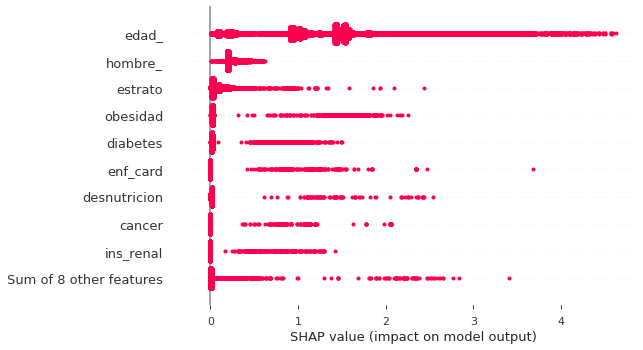

In [ ]:
# Importancia de Factores en valores Absolutos
shap.plots.beeswarm(shap_values.abs, color="shap_red")


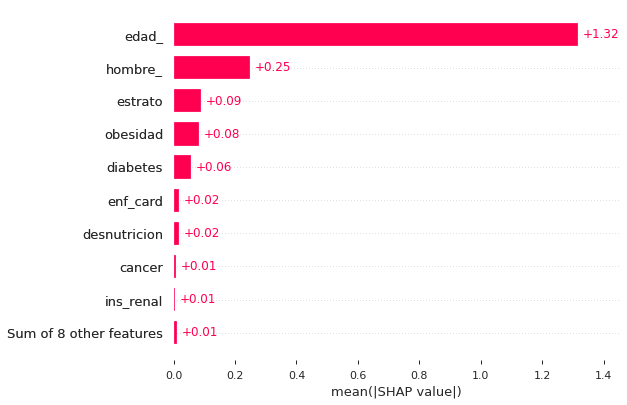

In [ ]:
# Importancia promedio de Factores en valores Absolutos
shap.plots.bar(shap_values)


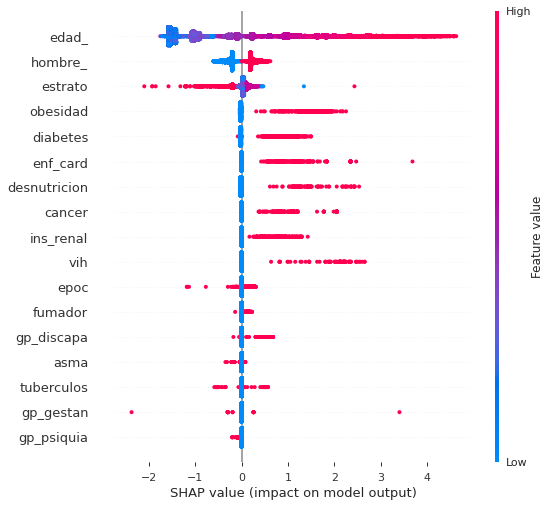

In [ ]:

# Importancia de Factores
shap.summary_plot(shap_values,X)

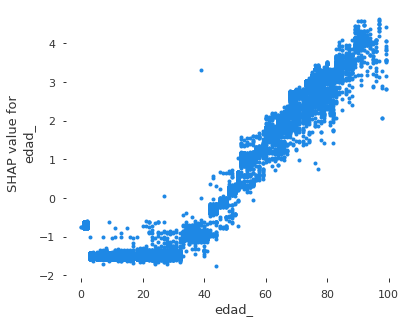

In [ ]:
# Shapley Values de la Edad
shap.dependence_plot("edad_", shap_values.values, X, interaction_index=None, )

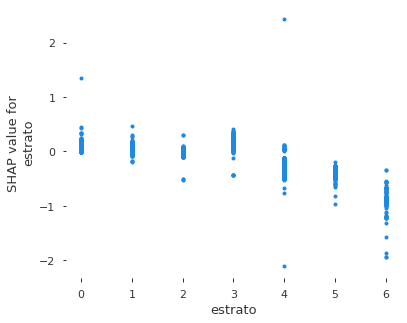

In [ ]:
# Shapley Values del Estrato
shap.dependence_plot("estrato", shap_values.values, X, interaction_index=None, )

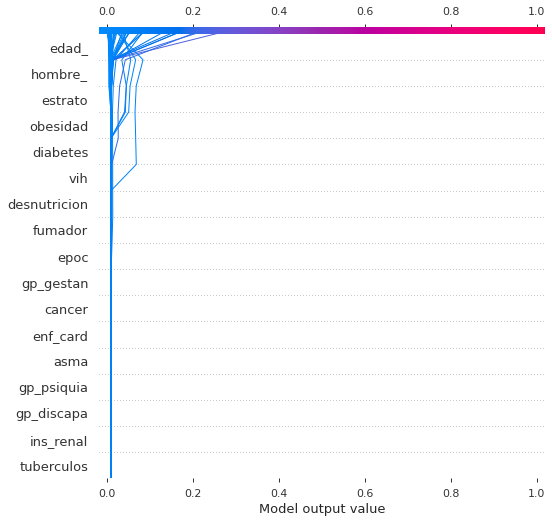

In [ ]:
# Variación de la Probabilidad por Factor
shap_sample_ix = np.random.randint(len(shap_values.values), size=100)
shap_samples = shap_values.values[shap_sample_ix]
shap.decision_plot(explainer.expected_value, shap_samples, feature_names=features, link='logit')

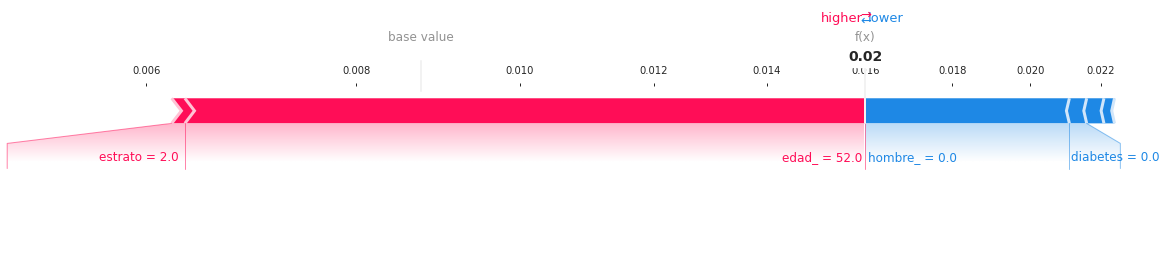

In [ ]:
# Explica el resultado de un individuo cualquiera
#Se debe introducir el individuo a explorar dos en cada corchete cuadrado (el de prueba es el 27)
shap.force_plot(explainer.expected_value, shap_values.values[27], X.loc[27], link='logit', matplotlib=True, feature_names=features)

In [ ]:
#Predictor del Riesgo de Fallecimiento

def dead_predictor(edad_, hombre_, comorbilidades):
  default_x = {
      'asma': 0, 'cancer': 0, 'desnutricion': 0, 'diabetes': 0,
      'edad_': edad_, 'enf_card': 0, 'epoc': 0, 'estrato': 3, 'fumador': 0,
      'gp_discapa': 0, 'gp_gestan': 0, 'gp_psiquia': 0, 'hombre_': hombre_,
      'ins_renal': 0, 'obesidad': 0, 'tuberculos': 0, 'vih': 0
  }
  default_x.update(comorbilidades)
  return best_model.predict_proba([[default_x[feat] for feat in features]])[0][1]

In [ ]:
# Age Span
age_span = list(range(0, 90, 10))

In [ ]:
# Comorbilidades
comorbilidades = {
 'cancer': 0,
 'desnutricion': 0,
 'diabetes': 0,
 'enf_card': 0,
 'estrato': 3,
 'gp_gestan': 0,
 'ins_renal': 0,
 'obesidad': 1,
 'vih': 0,
 #'asma': 0,
 #'tuberculos': 0,
 #'epoc': 0,
 #'gp_psiquia': 0,
 #'fumador': 0,
 #'gp_discapa': 0,
 #'fumador': 0,
 #'gp_discapa': 0,
}

go.Figure(
    data = [
            go.Scatter(
                x=age_span, 
                y=[dead_predictor(a, True, {}) for a in age_span],
                name='Hombres', line_color='gray', line_shape='spline',
                legendgroup='H', fill="tozeroy"
            ),
            go.Scatter(
                x=age_span, 
                y=[dead_predictor(a, False, {}) for a in age_span],
                name='Mujeres', line_color='red', line_shape='spline',
                legendgroup='M', fill="tozeroy"
            ),
            go.Scatter(
                x=age_span, 
                y=[dead_predictor(a, True, comorbilidades) for a in age_span],
                name='Hombres comorbilidad', line_color='gray', line_shape='spline',
                legendgroup='H', line_dash='dash', 
            ),
            go.Scatter(
                x=age_span, 
                y=[dead_predictor(a, False, comorbilidades) for a in age_span],
                name='Mujeres Comorbilidad', line_color='red', line_shape='spline',
                legendgroup='M', line_dash='dash', 
            )
            
            
    ],
    layout = go.Layout(
        title=dict(text='Simulador Riesgo de Fallecimiento', font_size=25),
        yaxis=dict(tickformat='.0%', title='Riesgo de Fallecimiento', range=[0, 1]),
        xaxis=dict(title='Edad, años'),
        template='plotly_white'
    )
)

In [ ]:
comorbilidades = [
 'hombre_',
 'cancer',
 'desnutricion',
 'diabetes',
 'enf_card',
 'ins_renal',
 'obesidad',
 'vih',
]


age_cmb = pd.Series(
    [dead_predictor(80, True, {cmb:1}) for cmb in comorbilidades],
    index=comorbilidades, 
).sort_values(ascending=False)

go.Figure(
    data = [ 
            go.Scatter(
        x=age_span, y=[dead_predictor(a, True, {cmb: 1}) for a in age_span],
        name=cmb) for cmb in age_cmb.index],
            


    layout = go.Layout(
        title=dict(text='COVID impacto comorbilidades', font_size=25),
        yaxis=dict(tickformat='.0%', title='Riesgo de Fallecimiento', range=[0, 0.6]),
        xaxis=dict(title='Edad, años'),
        template='plotly_white'

                
    )
)




In [ ]:
go.Figure(
    data = [go.Scatter(
        x=age_span, y=[dead_predictor(a, True, {'estrato': estrato}) for a in age_span],
        name='Estrato' + str(estrato), fill='tozeroy'
    ) for estrato in range(1, 7)],
    layout = go.Layout(
        title=dict(text='Riesgo de Fallecimiento por Estrato en Hombres', font_size=25),
        yaxis=dict(tickformat='.0%', title='Riesgo de Fallecimiento', range=[0, 0.4]),
        xaxis=dict(title='Edad, años'),
        template='plotly_white'
    )
)



> Diagramas de interacciones:





In [ ]:
shap_values2 = shap.TreeExplainer(best_model).shap_values(X)


In [ ]:
shap_interaction_values = shap.TreeExplainer(best_model).shap_interaction_values(X.iloc[:2000,:])

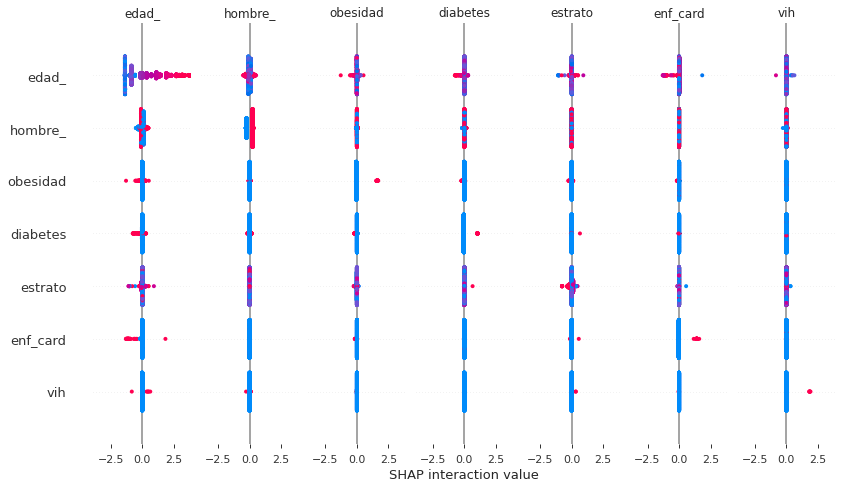

In [ ]:
shap.summary_plot(shap_interaction_values, X.iloc[:2000,:])

Matriz de correlaciones

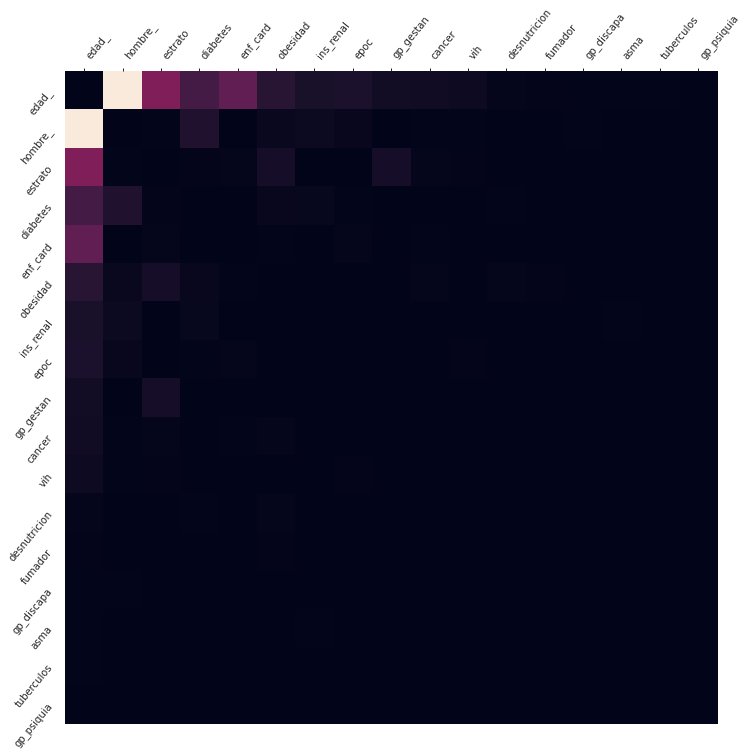

In [ ]:
import matplotlib.pylab as pl
import numpy as np
tmp = np.abs(shap_interaction_values).sum(0)
for i in range(tmp.shape[0]):
    tmp[i,i] = 0
inds = np.argsort(-tmp.sum(0))[:50]
tmp2 = tmp[inds,:][:,inds]
pl.figure(figsize=(12,12))
pl.imshow(tmp2)
pl.yticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="right")
pl.xticks(range(tmp2.shape[0]), X.columns[inds], rotation=50.4, horizontalalignment="left")
pl.gca().xaxis.tick_top()
pl.show()

Mapa de calor de shap values

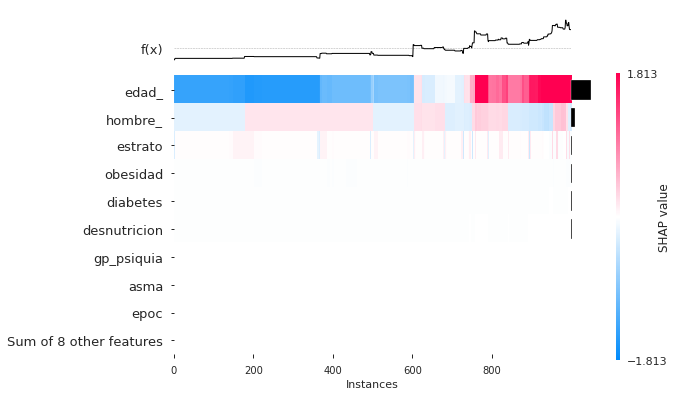

In [ ]:
import shap
shap_values = explainer(X[:1000])
shap.plots.heatmap(shap_values)
